In [1]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg as splin
import timeit
import matplotlib.pyplot as plt
################################################################################
def potential(x,y,d,sig):
    fac = 1.0/(np.sqrt(2.0*np.pi)*sig)
    r1  = np.exp(- (x**2.0 + (y-d/2.0)**2.0)/(2.0*sig**2.0))
    r2  =-np.exp(- (x**2.0 + (y+d/2.0)**2.0)/(2.0*sig**2.0))
    return fac*(r1+r2)
################################################################################
def setupA(J):   # fast method to set up sparse matrix
    N    = J*J
    dia  = -4*np.ones((N),float)  # diagonal element
    offJ = +1*np.ones((N),float)  # off-diagonal elements (+/- J)
    up   = +1*np.ones((N),float)  # off-diagonal elements (+ 1)
    up[range(J,N,J)] = 0
    dn   = +1*np.ones((N),float)   # off-diagonal elements (- 1)
    dn[range(J-1,N-1,J)] = 0
    vecs = np.array([offJ,dn,dia,up,offJ])   # join vectors 
    diags= np.array([-J,-1,0,+1,J])          # position of vectors in matrix 
    A    = sparse.spdiags(vecs, diags, N, N) # set up sparse (banded) matrix 
    A   = A.tocsr()  # convert sparse matrix to csr (Compressed Sparse Row) format
    return A
################################################################################
# MAIN PROGRAM 
# simulation box
x0 = -10.0; xN = +10.0
y0 = -10.0; yN = +10.0

Mrange = [20, 40 ,50, 80, 100,200,400]
count  = 0
t      = np.zeros((len(Mrange),7),float)
Nlist  = np.zeros((len(Mrange)),int)

for M in Mrange:
    h   = (xN - x0)/M
    x   = np.arange(x0+h,xN,h)
    y   = np.arange(y0+h,xN,h)
    X,Y = np.meshgrid(x, y)
    rho = potential(X,Y,5.0,0.5)
    J   = len(x)   # block size
    N   = J*J      # matrix size
    Nlist[count] = N

    A   = setupA(J)  # set up sparse matrix A
    b   = h*h*np.reshape(rho, (N)) # reshape right-hand side into a 1D-array

    start_time = timeit.default_timer()   
    phi = splin.spsolve(A, b)    # direct solution algorithm for sparse matrices
    t[count,0]  = timeit.default_timer() - start_time

    start_time = timeit.default_timer()   
    phi,info = splin.cg(A, b)  # conjugate gradient iteration
    t[count,1]  = timeit.default_timer() - start_time

    start_time = timeit.default_timer()   
    splin.bicg(A, b)  # BIConjugate Gradient iteration
    t[count,2]  = timeit.default_timer() - start_time

    start_time = timeit.default_timer()   
    phi,info = splin.gmres(A, b)  #Generalized Minimal RESidual iteration
    t[count,3]  = timeit.default_timer() - start_time

    start_time = timeit.default_timer()   
    phi,info = splin.lgmres(A, b)  #LGMRES algorithm
    t[count,4]  = timeit.default_timer() - start_time

    start_time = timeit.default_timer()   
    phi,info = splin.minres(A, b)  #MINimum RESidual iteration
    t[count,5]  = timeit.default_timer() - start_time

    start_time = timeit.default_timer()   
    phi,info = splin.qmr(A, b)  # Quasi-Minimal Residual iteration
    t[count,6]  = timeit.default_timer() - start_time

    count = count + 1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: DeprecationWarning: scipy.sparse.linalg.lgmres called without specifying `atol`. The default value will change in the future. To preserve current behavior, set ``atol=tol``.


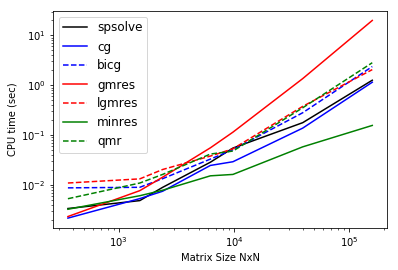

In [2]:
# plot current results
plt.loglog(Nlist,t[:,0],'k-',label='spsolve')
plt.loglog(Nlist,t[:,1],'b-',label='cg')
plt.loglog(Nlist,t[:,2],'b--',label='bicg')
plt.loglog(Nlist,t[:,3],'r-',label='gmres')
plt.loglog(Nlist,t[:,4],'r--',label='lgmres')
plt.loglog(Nlist,t[:,5],'g-',label='minres')
plt.loglog(Nlist,t[:,6],'g--',label='qmr')

plt.xlabel('Matrix Size NxN')
plt.ylabel('CPU time (sec)')
plt.legend(loc='upper left', shadow=False, fontsize=12)